In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats, optimize

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue_taylor.adjusters.adjust_annular import (set_init_point, prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale)
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces

Error: IPOPT shared library failed to import


Using TensorFlow backend.


In [2]:
nb_cells = 10
r_in = 110
r_out = 150

In [3]:
def print_tensions(exp_organo, th_organo):
    draw_specs = sheet_spec()
    tension_max = np.max(exp_organo.edge_df.line_tension.values.copy())
    edge_color = 1/tension_max*exp_organo.edge_df.line_tension.values.copy()
    cmap = plt.cm.get_cmap('viridis')
    edge_cmap = cmap(edge_color)
    draw_specs['vert']['visible'] = False
    draw_specs['edge']['color'] = edge_cmap
    draw_specs['edge']['width'] = 0.25+3*edge_color
    fig, ax = quick_edge_draw(th_organo, lw=5, c='k', alpha=0.2)
    fig, ax = sheet_view(exp_organo, ax=ax, **draw_specs)
    fig.set_size_inches(12, 12)
    plt.xlabel('Size in µm')
    plt.ylabel('Size in µm')

In [4]:
def rendering_results(x_data, y_data, title, xlabel, ylabel, legend):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
    fig, ax = plt.subplots()
    plt.plot(x_data, y_data, '.', markersize=10, alpha=0.4)
    plt.plot(x_data, intercept+slope*np.array(x_data), '-')
    plt.title(title, fontdict={'fontsize': 32})
    plt.legend(legend, loc='upper left', fontsize=16)
    plt.xlabel(xlabel, fontdict={'fontsize': 24})
    plt.ylabel(ylabel, fontdict={'fontsize': 24})
    fig.set_size_inches(12, 12)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()
    std = np.sum(np.power(intercept+slope*np.array(x_data)-y_data, 2))
    print('R value :', r_value,
          '\nStandard error :', (std/sym_organo.Ne)**0.5)

In [22]:
def rendering_convergence_results(x_data, y_data, title, xlabel, ylabel, legend, data_dot='-', rol_win=50):
    fig, ax = plt.subplots()
    plt.plot(x_data, y_data, data_dot, markersize=10, alpha=0.4)
    rolling = y_data.rolling(rol_win, min_periods=0, center=True).mean()
    plt.plot(x_data, rolling, data_dot, markersize=20, alpha=1)
    plt.title(title, fontdict={'fontsize': 32})
    plt.legend(legend, loc='upper left', fontsize=16)
    plt.xlabel(xlabel, fontdict={'fontsize': 24})
    plt.ylabel(ylabel, fontdict={'fontsize': 24})
    fig.set_size_inches(12, 12)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

# Synthetic case

In [5]:
seed = 1553
def create_organo(seed, nb_cells, r_in, r_out):
    organo = generate_ring(nb_cells, r_in, r_out)
    Nf= organo.Nf
    geom.update_all(organo)
    #alpha as proposed in the doc (in french) https://www.sharelatex.com/read/zdxptpnrryhc
    alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))


    # Model parameters or specifications
    specs = {
        'face':{
            'is_alive': 1,
            'prefered_area':  alpha*organo.face_df.area, 
            'area_elasticity': 1.,},
        'edge':{        
            'ux': 0.,
            'uy': 0.,
            'uz': 0.,
            'line_tension': 0.1,
            'is_active': 1
            },
        'vert':{
            'adhesion_strength': 0.,
            'x_ecm': 0.,
            'y_ecm': 0.,
            'is_active': 1
            },
        'settings': {
            'lumen_elasticity': 0.1,
            'lumen_prefered_vol': organo.settings['lumen_volume'],
            'lumen_volume': organo.settings['lumen_volume']
            }
        }

    organo.update_specs(specs, reset=True)
    normalize_scale(organo, geom, refer='edges')
    geom.update_all(organo)

    symetric_tensions = 10*set_init_point(organo.settings['R_in'], organo.settings['R_out'], organo.Nf, alpha)
    sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, organo.Nf, endpoint=False)))**2
    organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, organo.Nf)
    organo.edge_df.line_tension = prepare_tensions(organo, symetric_tensions)
    organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul*np.random.normal(1.0, 0.05, organo.Nf)

    organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]

    organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01

    new_tensions = organo.edge_df.line_tension

    organo.edge_df.loc[:,'line_tension'] = new_tensions

    res = Solver.find_energy_min(organo, geom, model) 
    return organo
sym_organo = create_organo(seed, 10, 110, 150)

Reseting datasets values with new specs


In [6]:
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}


bfgs_opt = {'method': 'bfgs','options': {'gtol':1e-1,'ftol': 1e-5}}
trf_opt = {'bounds': ([-1e-8]*(3*sym_organo.Nf),[1000]*(3*sym_organo.Nf)), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-3, 'verbose': 2}
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-3, 'verbose': 1}
psqp_opt = {'lb': 0, 'ub': 1e6, 'method': 'dist_PSQP', #'callback': printx,
            'output_path': './PSQP_areas.out'}

reg_weight = 1e-3
theta = 0.02

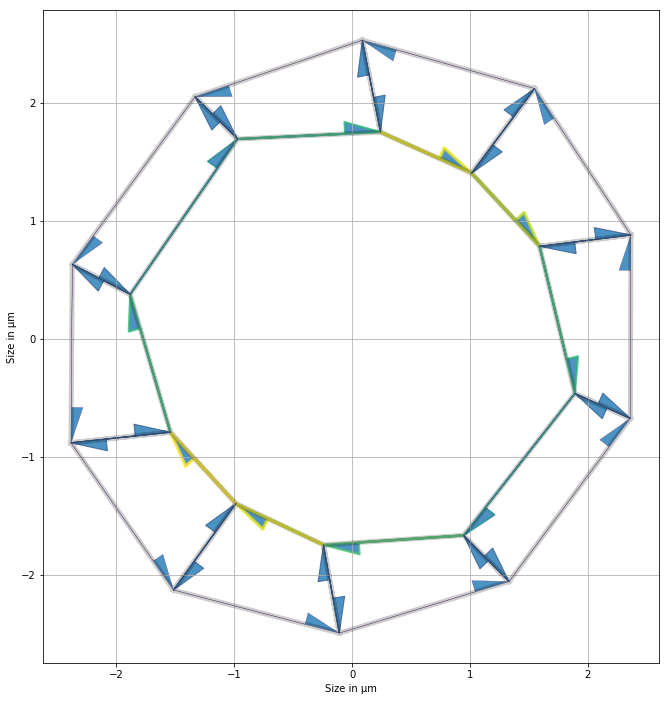

In [7]:
print_tensions(sym_organo, sym_organo)

## Force inference

Solving time: 8.591988
Distance from th organo to exp organo : 10.787066253338995
Distance from th tensions to exp tensions : 7.5123114507877915


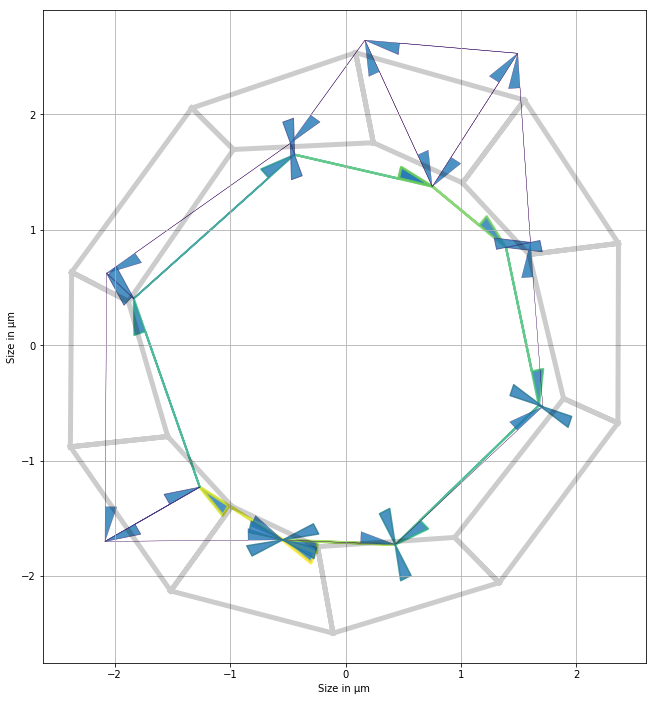

In [8]:
initial_guess = infer_forces(sym_organo, 'NNLS', sup_param='areas')
start = time.clock()
tensions_sym_organo = sym_organo.copy()
tensions_sym_organo.edge_df.line_tension = prepare_tensions(tensions_sym_organo,
                                                            initial_guess['tensions'])
tensions_sym_organo.face_df.prefered_area = sym_organo.face_df.area + initial_guess['areas'][:-1]
tensions_sym_organo.settings['lumen_prefered_volume'] = sym_organo.settings['lumen_volume'] + initial_guess['areas'][-1]
#print('Energy before optimization: ', model.compute_energy(tensions_sym_organo, False))
Solver.find_energy_min(tensions_sym_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
#print('Energy after optimization: ', model.compute_energy(tensions_sym_organo, False))
print_tensions(tensions_sym_organo, sym_organo)
print('Distance from th organo to exp organo : ' +
      str(np.sum(np.linalg.norm(_distance(sym_organo, tensions_sym_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(sym_organo.edge_df.line_tension[:3*nb_cells] - initial_guess['tensions']))))

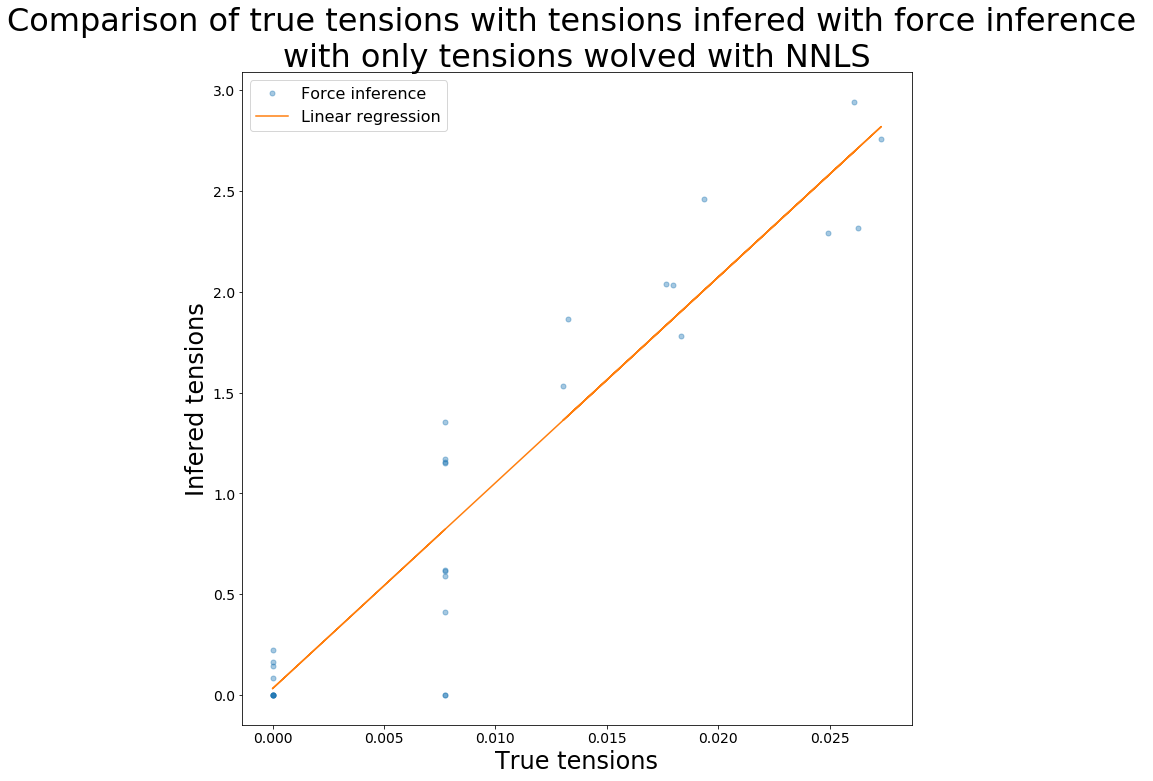

R value : 0.941079286886685 
Standard error : 0.2832607261995241


In [9]:
rendering_results(sym_organo.edge_df.line_tension[:3*sym_organo.Nf],
                  tensions_sym_organo.edge_df.line_tension[:3*sym_organo.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

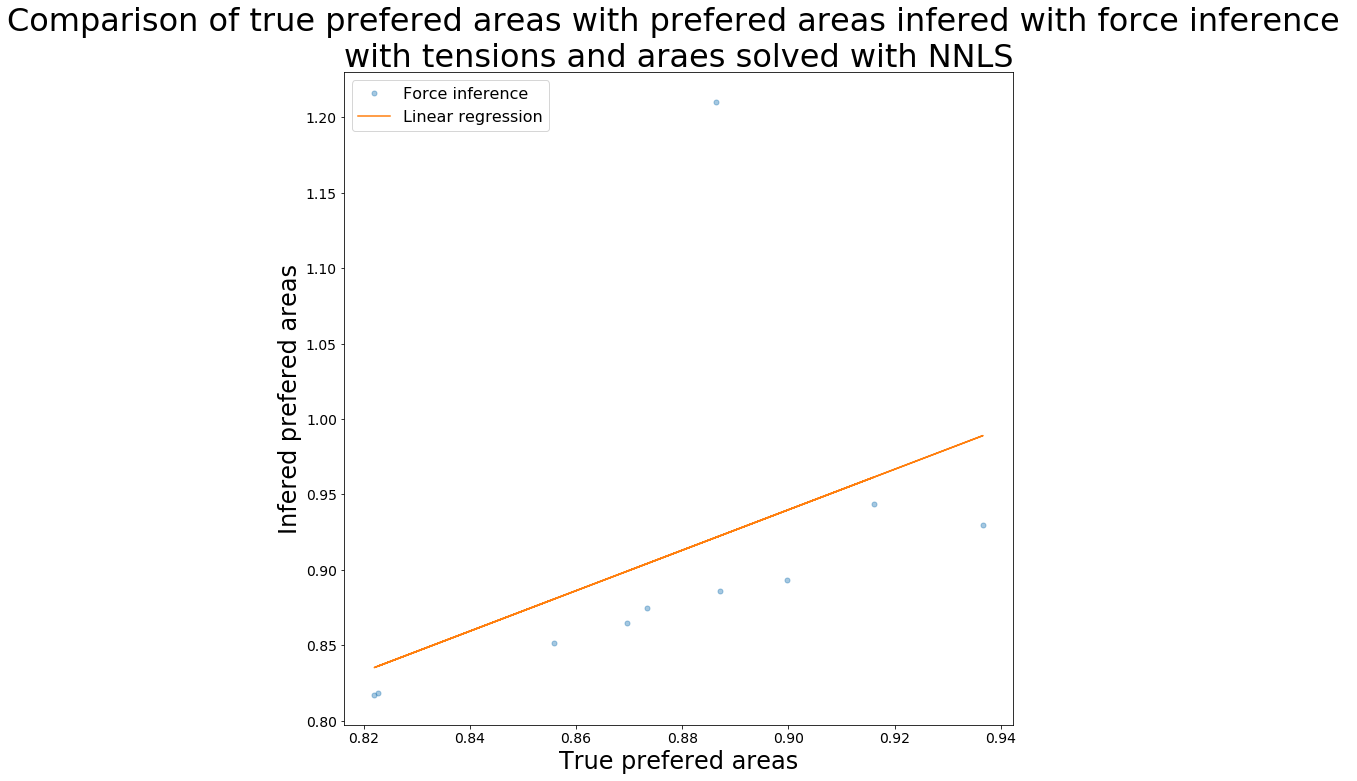

R value : 0.4363401315743376 
Standard error : 0.04848068703380642


In [10]:
rendering_results(sym_organo.face_df.prefered_area,
                  tensions_sym_organo.face_df.prefered_area,
                  'Comparison of true prefered areas with prefered areas infered with force inference \n' +
                  'with tensions and araes solved with NNLS',
                  'True prefered areas', 'Infered prefered areas', ('Force inference', 'Linear regression'))

## Scale factor optimization

Solving time: 110.703949
Distance from th sym_organo to exp sym_organo : 1.8035953642985538
Distance from th tensions to exp tensions : 0.03244917410552193


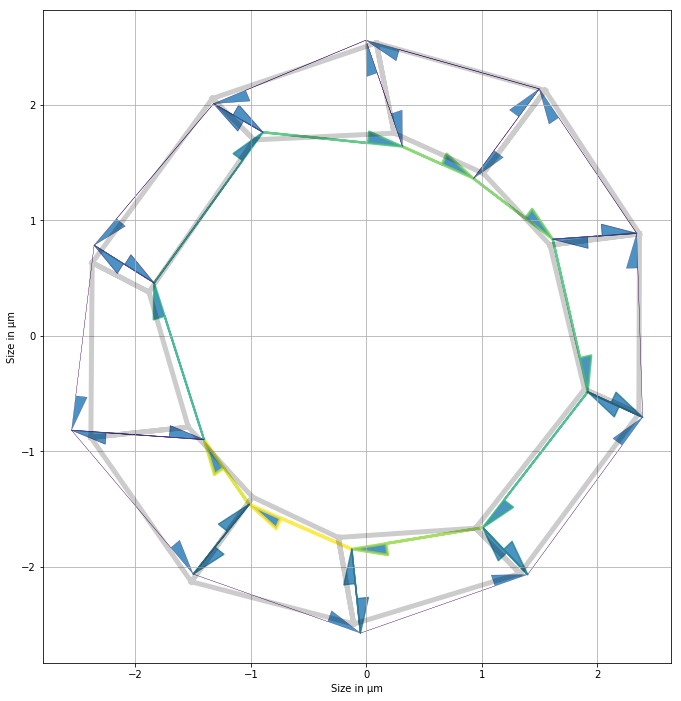

In [11]:
initial_guess = infer_forces(sym_organo, 'NNLS', sup_param='areas')
start = time.clock()
rescaled_tensions_sym_organo = sym_organo.copy()
opt_scale = adjust_scale(sym_organo,
                         initial_guess['tensions'],
                         **{'method':'Nelder-Mead'})
rescaled_tensions_sym_organo.edge_df.line_tension = prepare_tensions(rescaled_tensions_sym_organo,
                                                                 opt_scale.x*initial_guess['tensions'])
rescaled_tensions_sym_organo.face_df.prefered_area = sym_organo.face_df.area + initial_guess['areas'][:-1]
rescaled_tensions_sym_organo.settings['lumen_prefered_volume'] = sym_organo.settings['lumen_volume'] + initial_guess['areas'][-1]
Solver.find_energy_min(rescaled_tensions_sym_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(rescaled_tensions_sym_organo, sym_organo)
print('Distance from th sym_organo to exp sym_organo : ' +
      str(np.sum(np.linalg.norm(_distance(sym_organo, rescaled_tensions_sym_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(sym_organo.edge_df.line_tension[:3*nb_cells] -
                                rescaled_tensions_sym_organo.edge_df.line_tension[:3*nb_cells]))))

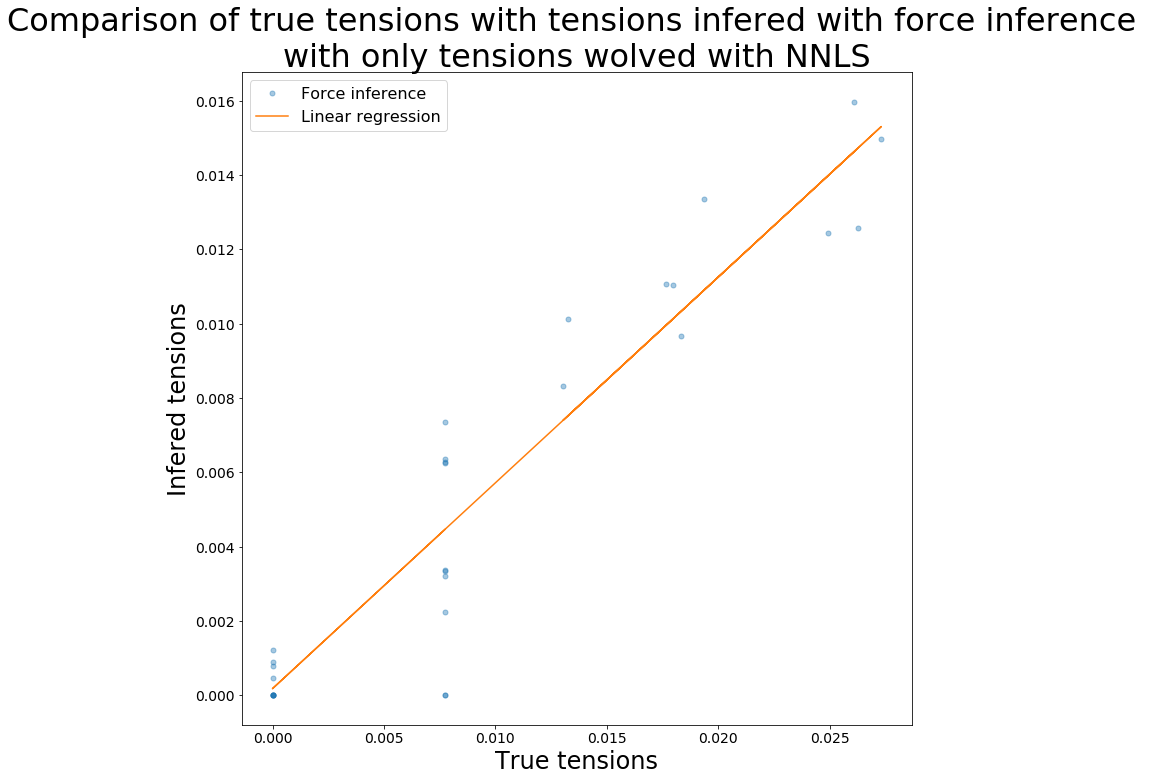

R value : 0.9410792868866847 
Standard error : 0.0015375746294017925


In [12]:
rendering_results(sym_organo.edge_df.line_tension[:3*sym_organo.Nf],
                  rescaled_tensions_sym_organo.edge_df.line_tension[:3*sym_organo.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

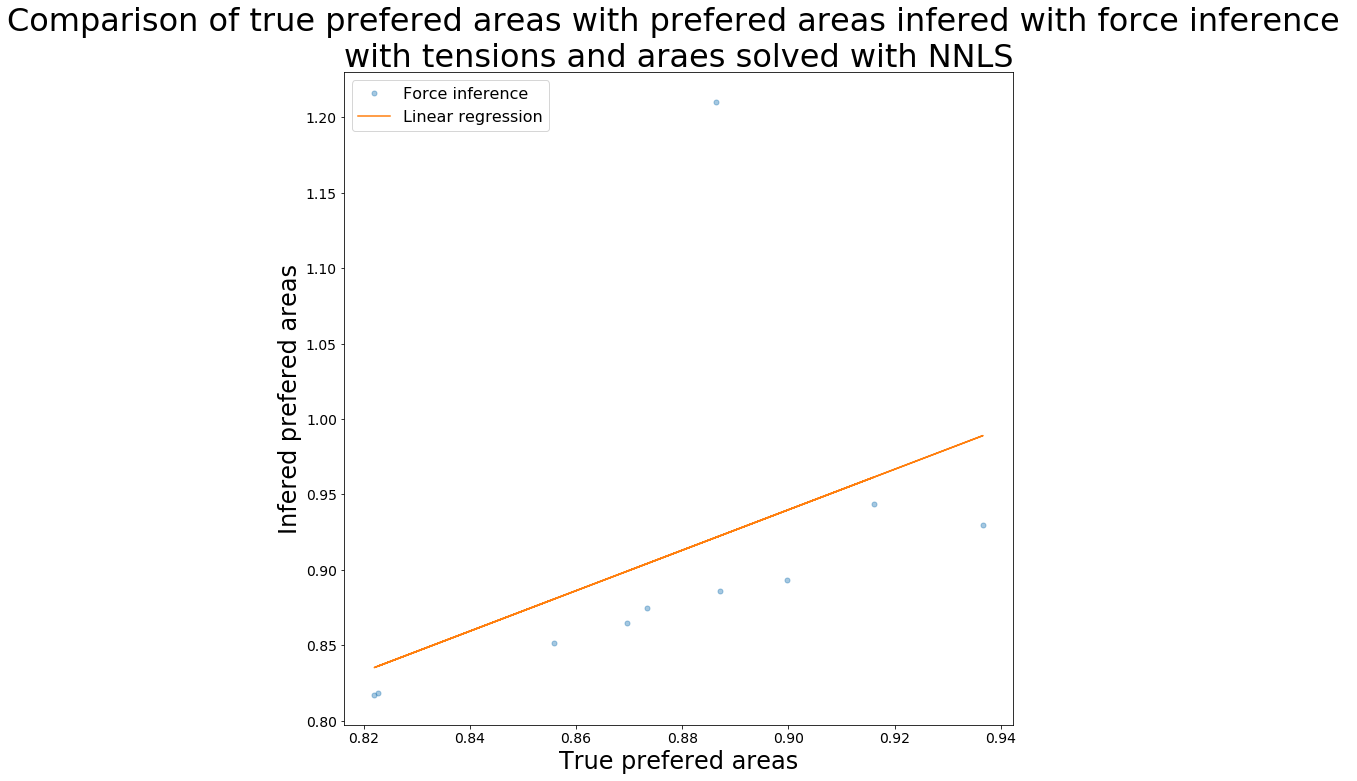

R value : 0.4363401315743376 
Standard error : 0.04848068703380642


In [13]:
rendering_results(sym_organo.face_df.prefered_area,
                  rescaled_tensions_sym_organo.face_df.prefered_area,
                  'Comparison of true prefered areas with prefered areas infered with force inference \n' +
                  'with tensions and araes solved with NNLS',
                  'True prefered areas', 'Infered prefered areas', ('Force inference', 'Linear regression'))

## Distance minimization

`ftol` termination condition is satisfied.
Function evaluations 874, initial cost 9.1124e-07, final cost 3.2130e-07, first-order optimality 5.46e-06.
Solving time: 263.712414
Distance from th sym_organo to exp sym_organo : 1.624032775833749
Distance from th tensions to exp tensions : 0.032407475588251695


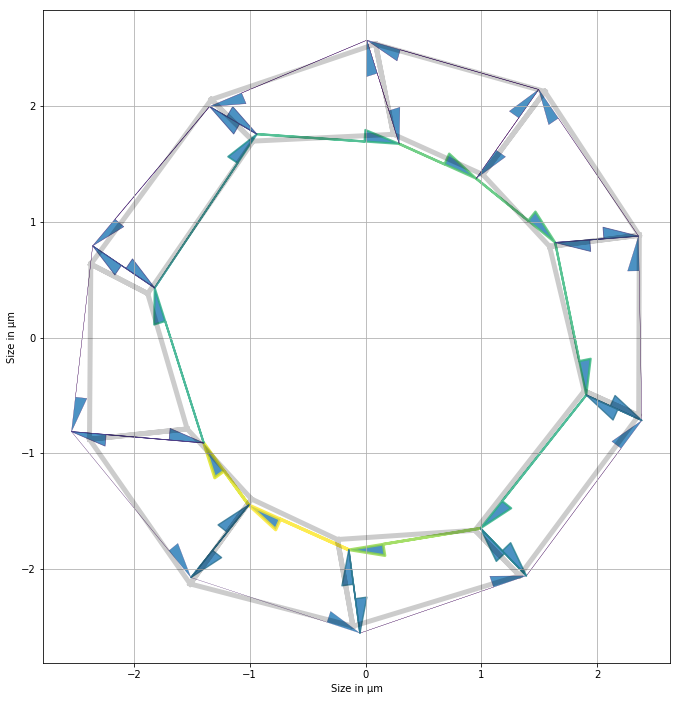

In [18]:
iprint_file = "../../assets/dist_at_each_f_ev/synth_tensions_and_areas.txt"
res_sym_tensions = adjust_tensions(rescaled_tensions_sym_organo,
                                   opt_scale.x*initial_guess['tensions'], 
                                   {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                                   energy_opt, iprint_file=iprint_file, **lm_opt)
opt_tensions_sym_organo = sym_organo.copy()
opt_tensions_sym_organo.edge_df.line_tension = prepare_tensions(opt_tensions_sym_organo, res_sym_tensions.x)
opt_tensions_sym_organo.face_df.prefered_area = sym_organo.face_df.area + initial_guess['areas'][:-1]
opt_tensions_sym_organo.settings['lumen_prefered_volume'] = sym_organo.settings['lumen_volume'] + initial_guess['areas'][-1]
Solver.find_energy_min(opt_tensions_sym_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(opt_tensions_sym_organo, sym_organo)
print('Distance from th sym_organo to exp sym_organo : ' +
      str(np.sum(np.linalg.norm(_distance(sym_organo, opt_tensions_sym_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(sym_organo.edge_df.line_tension[:3*nb_cells] -
                                opt_tensions_sym_organo.edge_df.line_tension[:3*nb_cells]))))

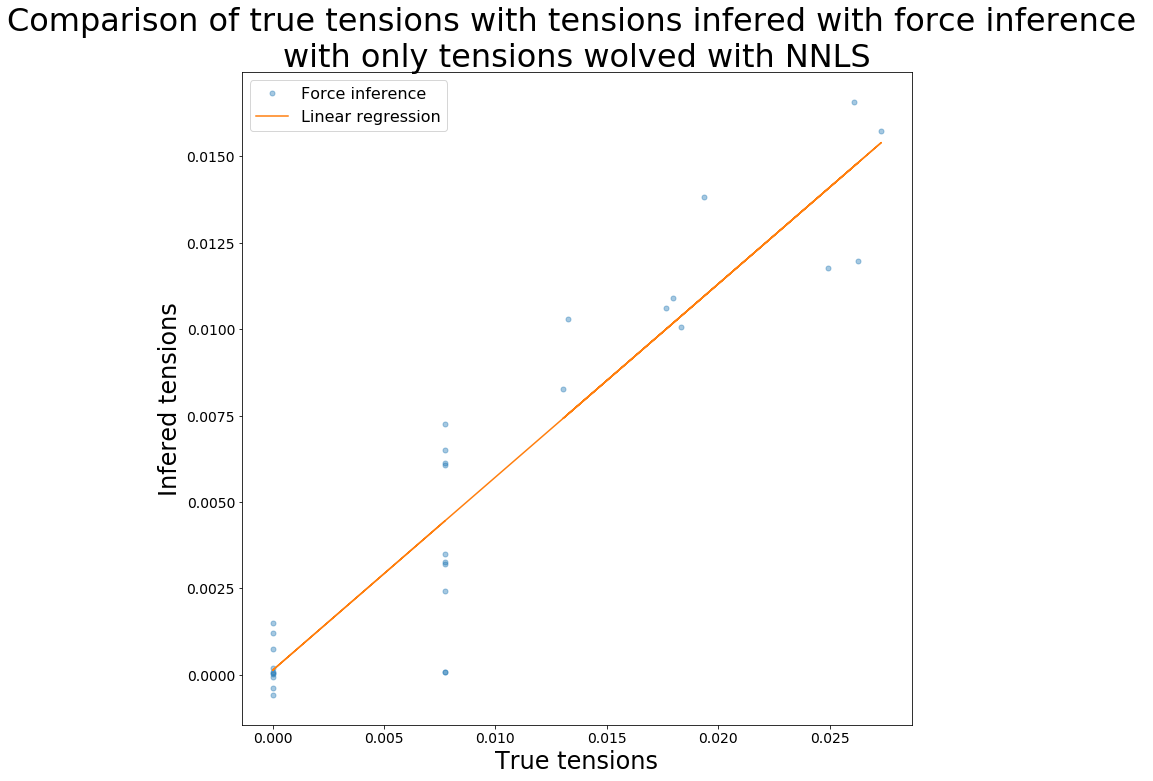

R value : 0.9376476000335744 
Standard error : 0.0016007041009540434


In [19]:
rendering_results(sym_organo.edge_df.line_tension[:3*sym_organo.Nf],
                  opt_tensions_sym_organo.edge_df.line_tension[:3*sym_organo.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

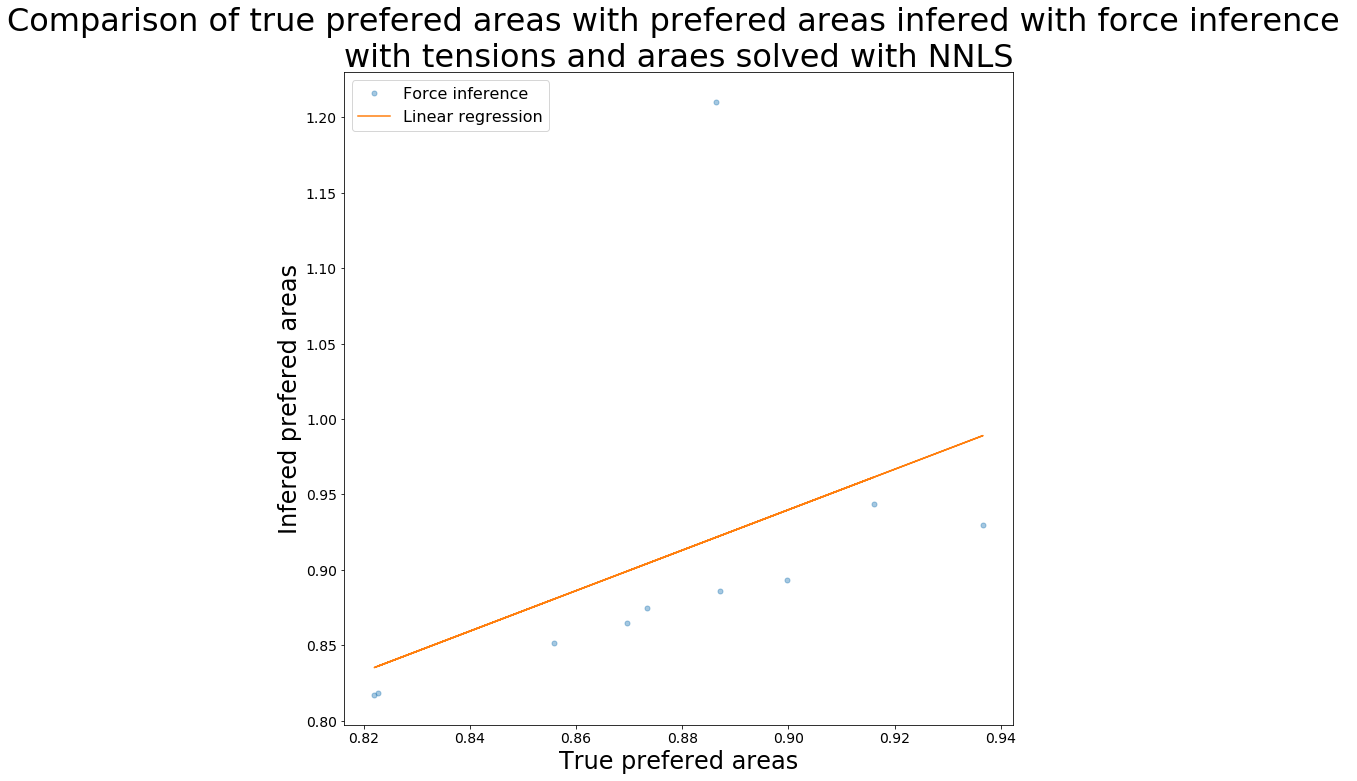

R value : 0.4363401315743376 
Standard error : 0.04848068703380642


In [20]:
rendering_results(sym_organo.face_df.prefered_area,
                  opt_tensions_sym_organo.face_df.prefered_area,
                  'Comparison of true prefered areas with prefered areas infered with force inference \n' +
                  'with tensions and araes solved with NNLS',
                  'True prefered areas', 'Infered prefered areas', ('Force inference', 'Linear regression'))

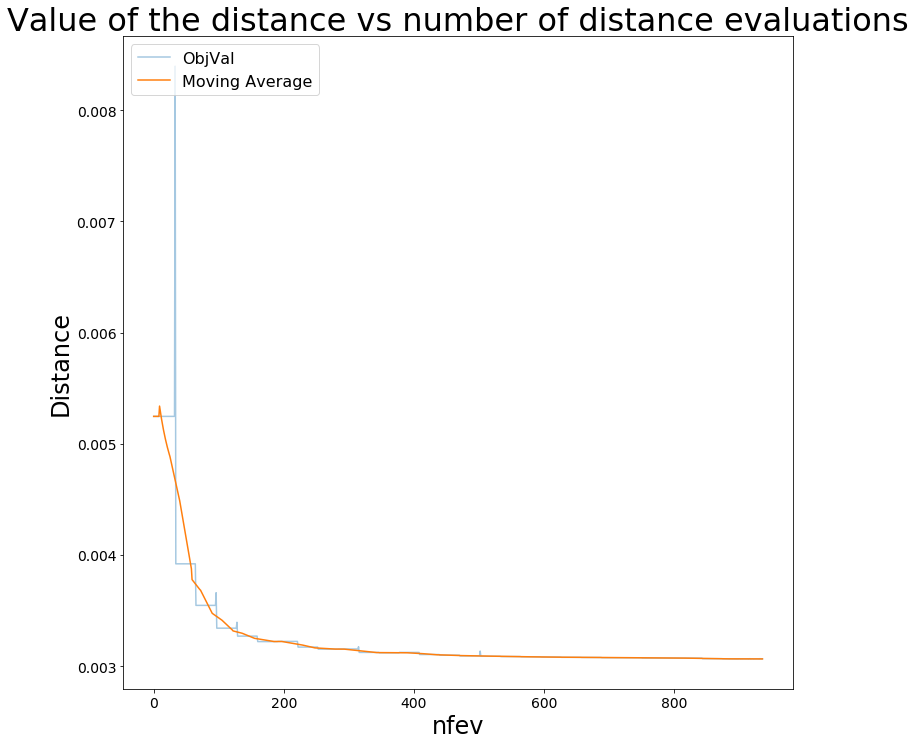

In [23]:
iter_data = pd.read_csv(iprint_file, header=None)
rendering_convergence_results(np.arange(len(iter_data[0])),
                              iter_data[0],
                              'Value of the distance vs number of distance evaluations',
                              'nfev', 'Distance', ('ObjVal', 'Moving Average'),
                              data_dot='-', rol_win=50)